# Feature Importance Analysis

**IMPORTANT**: This notebook analyzes **EXISTING features** that are already in the database (`v_features_icu_stay_clean`).

## What This Notebook Does:
1. ✅ **Analyzes existing features** - Shows which features currently in the database are most important
2. ✅ **Identifies patterns** - Reveals which categories (Vitals, Labs, APACHE, etc.) are most predictive
3. ✅ **Informs recommendations** - Uses these insights to suggest NEW features to create

## What This Notebook Does NOT Do:
- ❌ **Does NOT analyze new features** - The recommended features in the SQL file don't exist yet
- ❌ **Does NOT test new features** - Those need to be implemented first, then we can re-run this analysis

## Workflow:
1. **Step 1 (This Notebook)**: Analyze importance of existing features → Identify patterns
2. **Step 2 (SQL File)**: Create NEW features based on patterns + clinical knowledge
3. **Step 3 (Future)**: Implement new features → Re-run this notebook → See if they're actually important

**Goal**: Use insights from existing features to guide creation of NEW engineered features.

In [1]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.inspection import permutation_importance

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load Data

In [2]:
# Load data
conn = duckdb.connect("../../data/duckdb/fedlearn.duckdb", read_only=True)
df = conn.execute("select * from v_features_icu_stay_clean").df()
df = df.where(df.notna(), np.nan)

print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")

# Prepare target and features
y = df["prolonged_stay"]
X = df.drop(columns=["patientunitstayid", "los_days", "prolonged_stay", "apacheadmissiondx"])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Total samples: 199,646
Total features: 103

Feature matrix shape: (199646, 99)
Target distribution:
prolonged_stay
0    150206
1     49440
Name: count, dtype: int64


## 2. Feature Overview

In [3]:
# Categorize features by type
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"\nCategorical features: {categorical_features}")

Numeric features: 89
Categorical features: 10

Categorical features: ['age_group', 'gender', 'ethnicity', 'unittype', 'unitadmitsource', 'hospitaladmitsource', 'admissiondx_category', 'numbedscategory', 'teachingstatus', 'hospital_region']


## 3. Train Models for Feature Importance

In [4]:
def build_preprocessor(X):
    numeric_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(exclude=["number"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", numeric_transformer, numeric_features),
            ("categorical", categorical_transformer, categorical_features),
        ],
    )

    return preprocessor

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Training samples: 159,716
Test samples: 39,930


In [5]:
# Train Random Forest
print("Training Random Forest...")
rf_pipeline = Pipeline([
    ("preprocessor", build_preprocessor(X)),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )),
])

rf_pipeline.fit(X_train, y_train)
print("Random Forest trained!")

# Train Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_pipeline = Pipeline([
    ("preprocessor", build_preprocessor(X)),
    ("classifier", GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
    )),
])

gb_pipeline.fit(X_train, y_train)
print("Gradient Boosting trained!")

Training Random Forest...
Random Forest trained!

Training Gradient Boosting...
Gradient Boosting trained!


## 4. Extract Feature Names After Preprocessing

In [6]:
# Get feature names after preprocessing
preprocessor = rf_pipeline.named_steps['preprocessor']

# Numeric feature names
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Categorical feature names (after one-hot encoding)
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()
cat_encoder = preprocessor.named_transformers_['categorical'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = numeric_features + list(cat_feature_names)

print(f"Total features after preprocessing: {len(all_feature_names)}")
print(f"  Numeric: {len(numeric_features)}")
print(f"  Categorical (one-hot): {len(cat_feature_names)}")

Total features after preprocessing: 158
  Numeric: 89
  Categorical (one-hot): 69


## 5. Random Forest Feature Importance

In [7]:
# Get Random Forest feature importances
rf_classifier = rf_pipeline.named_steps['classifier']
rf_importances = rf_classifier.feature_importances_

# Create DataFrame
rf_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=False)

print("Top 30 features (Random Forest):")
print(rf_importance_df.head(30).to_string(index=False))

Top 30 features (Random Forest):
                      feature  importance
     vent_started_24h_missing    0.117528
                  apache_vent    0.063331
           apache_oobventday1    0.061783
              apache_ventday1    0.048182
          apache_oobintubday1    0.040180
             apache_gcs_total    0.036270
            apache_gcs_verbal    0.027654
                   max_hr_24h    0.025536
               sao2_range_24h    0.025410
                   apache_bun    0.022758
             apache_gcs_motor    0.022237
             apache_intubated    0.020683
           creatinine_max_24h    0.019734
                    apache_hr    0.015456
              apache_gcs_eyes    0.014932
          creatinine_mean_24h    0.014502
                 min_sao2_24h    0.014170
                   avg_hr_24h    0.013666
        sedative_propofol_24h    0.012885
                 wbc_mean_24h    0.012783
                 hr_range_24h    0.012332
                 avg_sao2_24h    0.012317
 

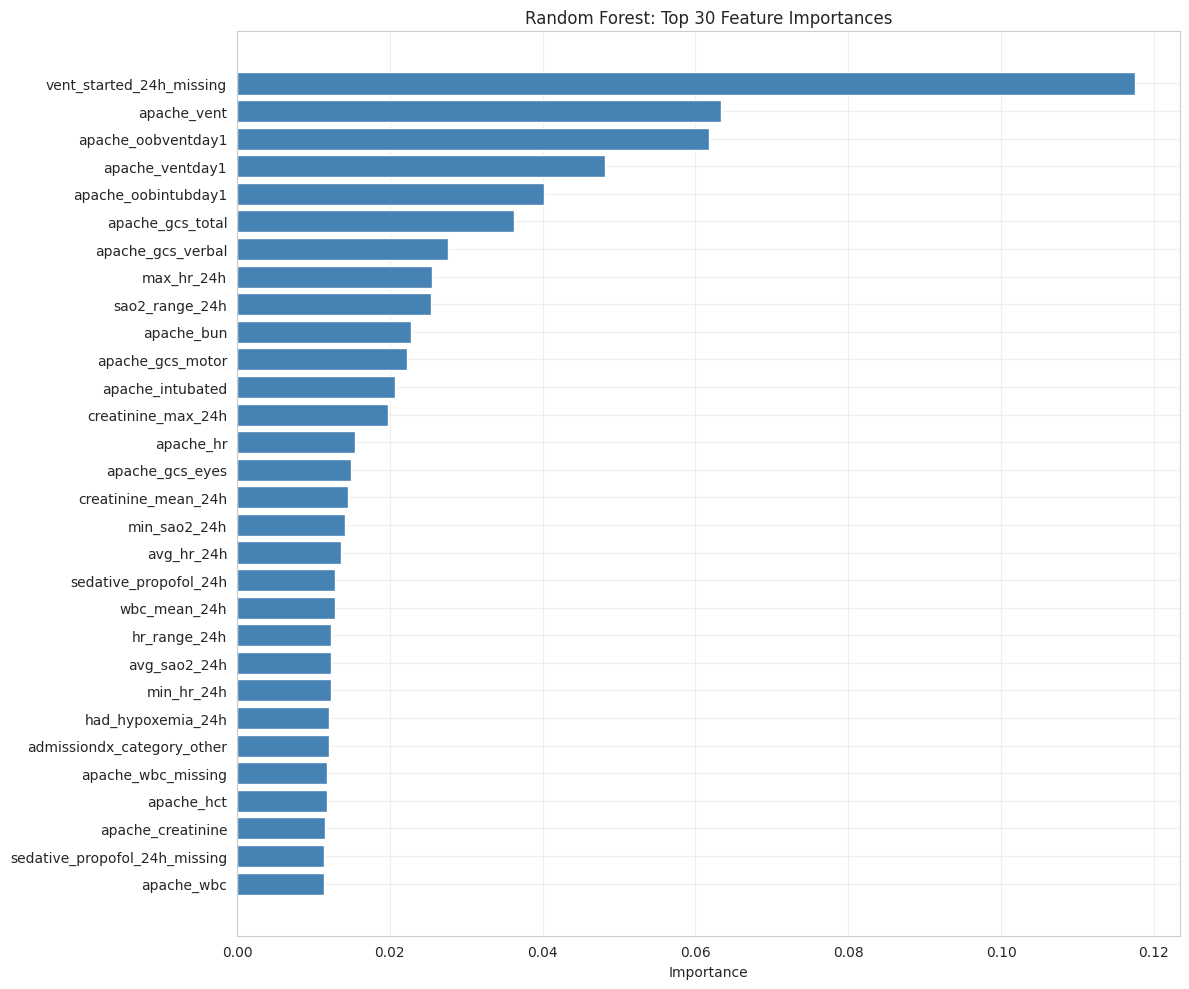

In [8]:
# Visualize top 30 features
fig, ax = plt.subplots(figsize=(12, 10))
top_30_rf = rf_importance_df.head(30)
ax.barh(range(30), top_30_rf['importance'].values[::-1], color='steelblue')
ax.set_yticks(range(30))
ax.set_yticklabels(top_30_rf['feature'].values[::-1])
ax.set_xlabel('Importance')
ax.set_title('Random Forest: Top 30 Feature Importances')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Gradient Boosting Feature Importance

In [9]:
# Get Gradient Boosting feature importances
gb_classifier = gb_pipeline.named_steps['classifier']
gb_importances = gb_classifier.feature_importances_

# Create DataFrame
gb_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': gb_importances
}).sort_values('importance', ascending=False)

print("Top 30 features (Gradient Boosting):")
print(gb_importance_df.head(30).to_string(index=False))

Top 30 features (Gradient Boosting):
                       feature  importance
      vent_started_24h_missing    0.328121
           apache_oobintubday1    0.041605
            apache_oobventday1    0.041060
                sao2_range_24h    0.032616
                    max_hr_24h    0.029428
                    min_hr_24h    0.027781
                  avg_sao2_24h    0.027299
              apache_gcs_total    0.022592
                    apache_bun    0.022340
                  wbc_mean_24h    0.021564
            creatinine_max_24h    0.021210
               apache_ventday1    0.018933
    admissiondx_category_other    0.017786
apache_electivesurgery_missing    0.016808
         creatinine_change_24h    0.015130
                    apache_hct    0.015030
                   apache_vent    0.013737
           creatinine_mean_24h    0.013660
               apache_bedcount    0.011745
                apache_albumin    0.011712
                    avg_hr_24h    0.011271
          hospita

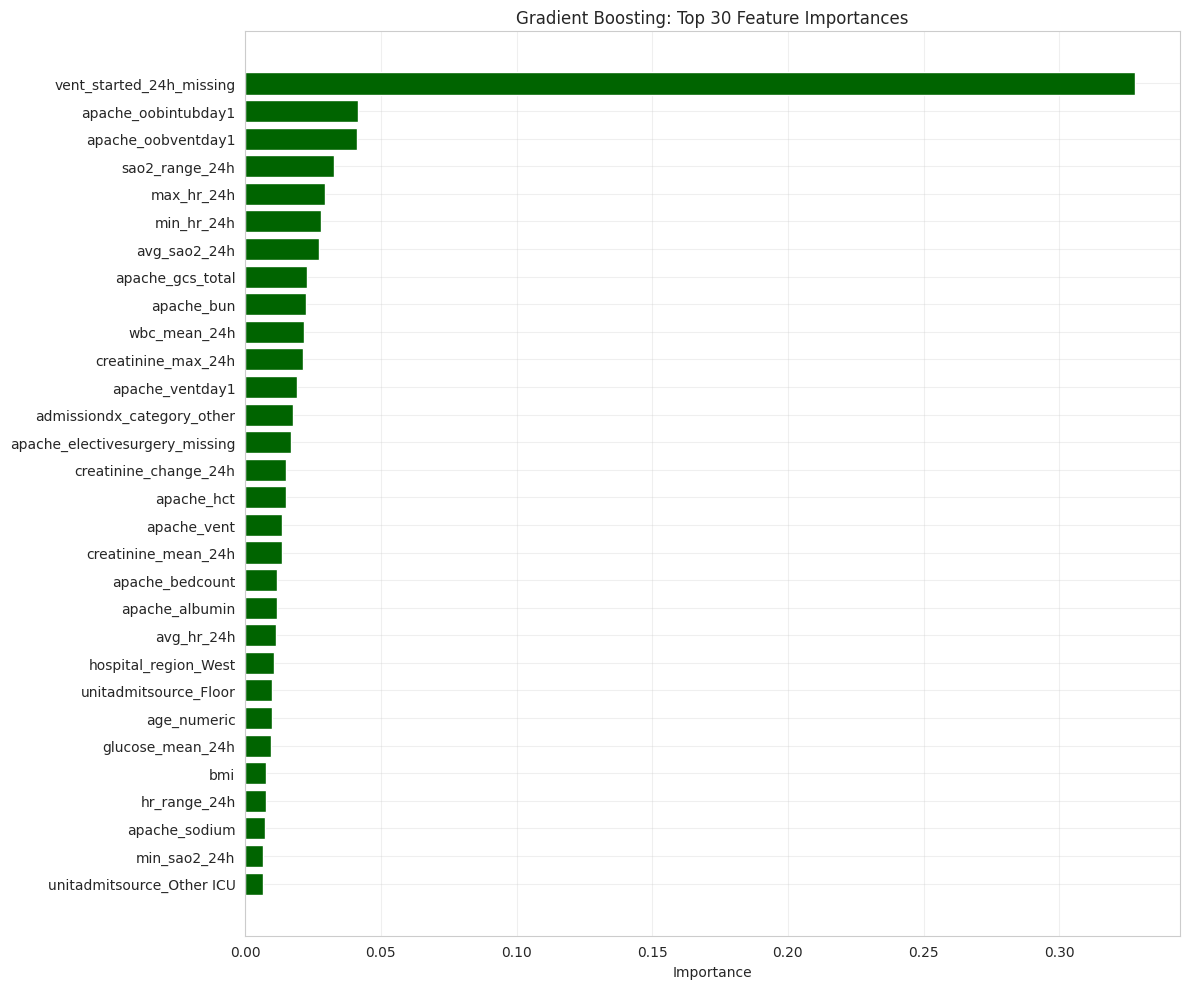

In [10]:
# Visualize top 30 features
fig, ax = plt.subplots(figsize=(12, 10))
top_30_gb = gb_importance_df.head(30)
ax.barh(range(30), top_30_gb['importance'].values[::-1], color='darkgreen')
ax.set_yticks(range(30))
ax.set_yticklabels(top_30_gb['feature'].values[::-1])
ax.set_xlabel('Importance')
ax.set_title('Gradient Boosting: Top 30 Feature Importances')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Compare Feature Importances Across Models

In [11]:
# Merge importance dataframes
comparison_df = pd.merge(
    rf_importance_df.rename(columns={'importance': 'rf_importance'}),
    gb_importance_df.rename(columns={'importance': 'gb_importance'}),
    on='feature'
)

# Calculate average importance
comparison_df['avg_importance'] = (comparison_df['rf_importance'] + comparison_df['gb_importance']) / 2
comparison_df = comparison_df.sort_values('avg_importance', ascending=False)

print("Top 30 features (averaged across models):")
print(comparison_df.head(30).to_string(index=False))

Top 30 features (averaged across models):
                       feature  rf_importance  gb_importance  avg_importance
      vent_started_24h_missing       0.117528       0.328121        0.222824
            apache_oobventday1       0.061783       0.041060        0.051421
           apache_oobintubday1       0.040180       0.041605        0.040893
                   apache_vent       0.063331       0.013737        0.038534
               apache_ventday1       0.048182       0.018933        0.033558
              apache_gcs_total       0.036270       0.022592        0.029431
                sao2_range_24h       0.025410       0.032616        0.029013
                    max_hr_24h       0.025536       0.029428        0.027482
                    apache_bun       0.022758       0.022340        0.022549
            creatinine_max_24h       0.019734       0.021210        0.020472
                    min_hr_24h       0.012248       0.027781        0.020014
                  avg_sao2_24h    

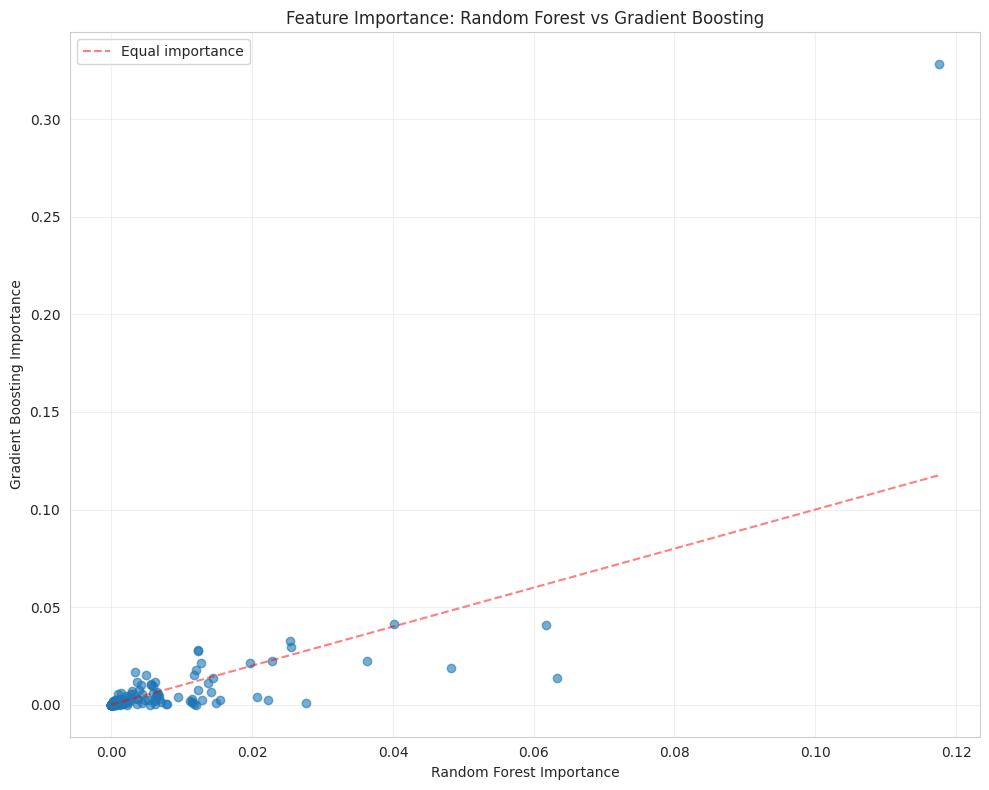

In [12]:
# Scatter plot comparing importances
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(comparison_df['rf_importance'], comparison_df['gb_importance'], alpha=0.6)
ax.plot([0, comparison_df['rf_importance'].max()], 
        [0, comparison_df['rf_importance'].max()], 
        'r--', alpha=0.5, label='Equal importance')
ax.set_xlabel('Random Forest Importance')
ax.set_ylabel('Gradient Boosting Importance')
ax.set_title('Feature Importance: Random Forest vs Gradient Boosting')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Analyze Feature Groups

In [13]:
# Categorize features into groups
def categorize_feature(feature_name):
    if 'apache' in feature_name.lower():
        return 'APACHE'
    elif any(x in feature_name.lower() for x in ['hr', 'rr', 'sao2', 'temp', 'meanbp']):
        return 'Vitals'
    elif any(x in feature_name.lower() for x in ['creatinine', 'wbc', 'glucose', 'albumin', 'bilirubin']):
        return 'Labs'
    elif any(x in feature_name.lower() for x in ['pressor', 'sedative', 'vent']):
        return 'Interventions'
    elif 'missing' in feature_name.lower():
        return 'Missingness'
    elif any(x in feature_name.lower() for x in ['age', 'gender', 'ethnicity', 'bmi']):
        return 'Demographics'
    elif any(x in feature_name.lower() for x in ['hospital', 'unit', 'teaching', 'bedcount']):
        return 'Hospital'
    elif any(x in feature_name.lower() for x in ['admissiondx', 'region']):
        return 'Diagnosis/Location'
    else:
        return 'Other'

# Add category column
comparison_df['category'] = comparison_df['feature'].apply(categorize_feature)

# Aggregate by category
category_importance = comparison_df.groupby('category').agg({
    'avg_importance': 'sum',
    'feature': 'count'
}).rename(columns={'feature': 'feature_count'}).sort_values('avg_importance', ascending=False)

print("Feature importance by category:")
print(category_importance)

Feature importance by category:
                    avg_importance  feature_count
category                                         
APACHE                    0.397925             48
Interventions             0.271072             11
Vitals                    0.149000             12
Labs                      0.069512              5
Hospital                  0.053962             45
Diagnosis/Location        0.019989              7
Other                     0.019847             11
Demographics              0.016445             16
Missingness               0.002248              3


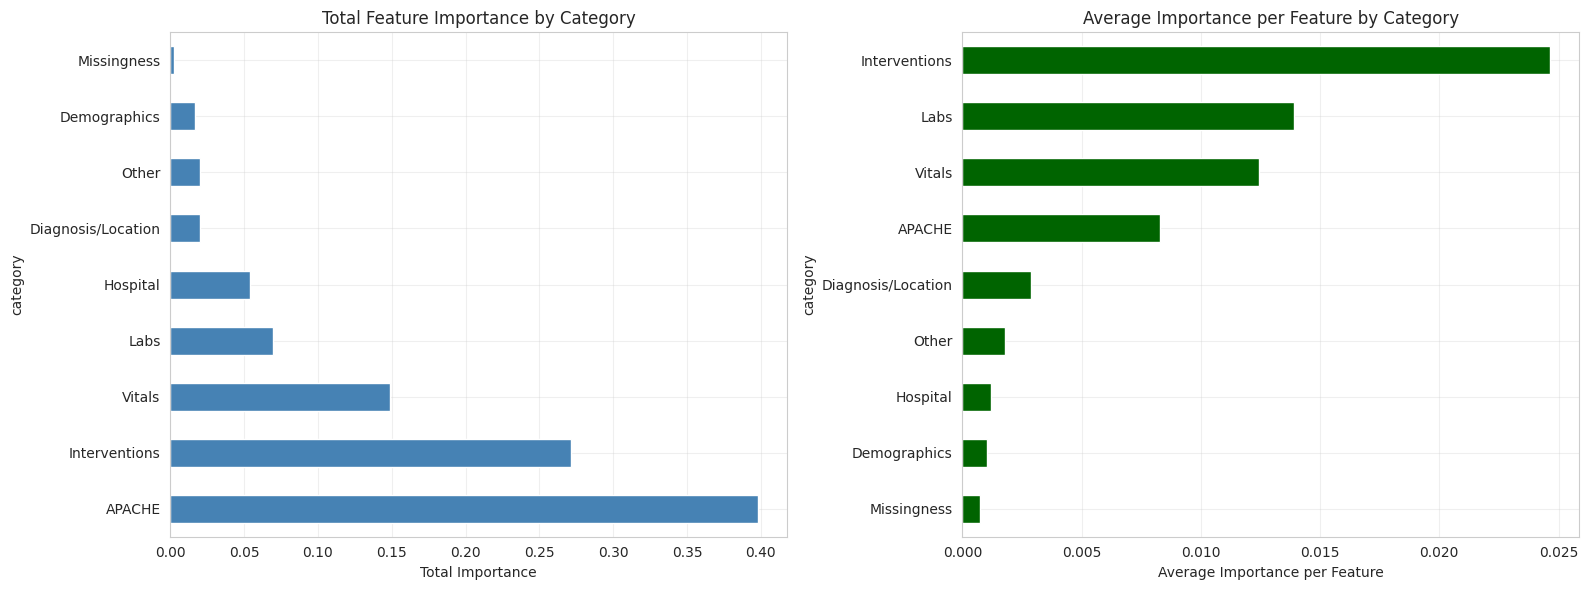

In [14]:
# Visualize category importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Total importance by category
category_importance['avg_importance'].plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Total Importance')
ax1.set_title('Total Feature Importance by Category')
ax1.grid(True, alpha=0.3)

# Average importance per feature by category
category_avg = comparison_df.groupby('category')['avg_importance'].mean().sort_values(ascending=True)
category_avg.plot(kind='barh', ax=ax2, color='darkgreen')
ax2.set_xlabel('Average Importance per Feature')
ax2.set_title('Average Importance per Feature by Category')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Key Insights

In [15]:
print("=" * 80)
print("KEY INSIGHTS FROM FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Top 10 most important features
top_10 = comparison_df.head(10)
print("\n1. TOP 10 MOST IMPORTANT FEATURES:")
for i, row in top_10.iterrows():
    print(f"   {row['feature']:50s} (avg: {row['avg_importance']:.4f}, category: {row['category']})")

# Most important categories
print("\n2. MOST IMPORTANT FEATURE CATEGORIES:")
for category, data in category_importance.head(5).iterrows():
    print(f"   {category:20s}: {data['avg_importance']:.4f} total importance ({data['feature_count']} features)")

# Underrepresented but important features
print("\n3. HIGH-VALUE SINGLE FEATURES (top within their category):")
for category in comparison_df['category'].unique():
    top_in_cat = comparison_df[comparison_df['category'] == category].head(1)
    if not top_in_cat.empty:
        row = top_in_cat.iloc[0]
        print(f"   [{category:20s}] {row['feature']:40s} (importance: {row['avg_importance']:.4f})")

print("\n" + "="*80)

KEY INSIGHTS FROM FEATURE IMPORTANCE ANALYSIS

1. TOP 10 MOST IMPORTANT FEATURES:
   vent_started_24h_missing                           (avg: 0.2228, category: Interventions)
   apache_oobventday1                                 (avg: 0.0514, category: APACHE)
   apache_oobintubday1                                (avg: 0.0409, category: APACHE)
   apache_vent                                        (avg: 0.0385, category: APACHE)
   apache_ventday1                                    (avg: 0.0336, category: APACHE)
   apache_gcs_total                                   (avg: 0.0294, category: APACHE)
   sao2_range_24h                                     (avg: 0.0290, category: Vitals)
   max_hr_24h                                         (avg: 0.0275, category: Vitals)
   apache_bun                                         (avg: 0.0225, category: APACHE)
   creatinine_max_24h                                 (avg: 0.0205, category: Labs)

2. MOST IMPORTANT FEATURE CATEGORIES:
   APACHE     

## 10. Feature Engineering Recommendations

**IMPORTANT**: The features below are **NEW features that do NOT exist yet** in the database.

### How These Recommendations Were Created:
1. ✅ **Based on analysis above** - We saw that Interventions, APACHE scores, and Vitals are important
2. ✅ **Clinical knowledge** - These are validated scores used in ICU medicine (SOFA, qSOFA, SIRS)
3. ✅ **Feature engineering principles** - Ratios and composite scores often capture more signal

### Next Steps:
1. **Jim implements** these features in the SQL views (see `phase4_advanced_features.sql`)
2. **Re-run models** to see if performance improves
3. **Re-run THIS notebook** to see which NEW features are actually important

These are **recommendations to be tested**, not proven features yet.

In [16]:
recommendations = [
    {
        "category": "Clinical Severity Scores",
        "features": [
            "SOFA score (Sequential Organ Failure Assessment)",
            "qSOFA score (quick SOFA)",
            "SIRS criteria count (Systemic Inflammatory Response Syndrome)",
            "Shock index (HR / systolic BP)",
        ],
        "rationale": "These composite scores capture overall patient severity and are strongly predictive of outcomes"
    },
    {
        "category": "Vital Sign Variability",
        "features": [
            "Coefficient of variation for HR, RR, SaO2",
            "Standard deviation of vitals over 24h",
            "Rate of change (delta) in vitals",
        ],
        "rationale": "Variability in vitals often indicates instability and poor prognosis"
    },
    {
        "category": "Lab Ratios",
        "features": [
            "BUN/Creatinine ratio",
            "WBC/Albumin ratio",
            "Glucose/Creatinine ratio",
        ],
        "rationale": "Ratios can capture relationships between lab values that single values miss"
    },
    {
        "category": "Intervention Intensity",
        "features": [
            "Total pressor count (number of different pressors)",
            "Ventilation + pressor combination flag",
            "Dialysis + pressor combination flag",
        ],
        "rationale": "Combination of interventions indicates higher severity"
    },
    {
        "category": "Organ Dysfunction Indicators",
        "features": [
            "Respiratory dysfunction: (vent OR low SaO2)",
            "Cardiovascular dysfunction: (pressor OR low BP)",
            "Renal dysfunction: (AKI OR dialysis)",
            "Total organ systems affected",
        ],
        "rationale": "Multi-organ dysfunction is strongly associated with prolonged ICU stay"
    },
    {
        "category": "Temporal Features",
        "features": [
            "Time to first pressor (if applicable)",
            "Time to ventilation (if applicable)",
            "Early deterioration flag (worsening in first 24h)",
        ],
        "rationale": "Timing of interventions can predict trajectory"
    },
]

print("=" * 80)
print("FEATURE ENGINEERING RECOMMENDATIONS")
print("=" * 80)

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['category'].upper()}")
    print(f"   Rationale: {rec['rationale']}")
    print("   Features:")
    for feature in rec['features']:
        print(f"     - {feature}")

print("\n" + "="*80)

FEATURE ENGINEERING RECOMMENDATIONS

1. CLINICAL SEVERITY SCORES
   Rationale: These composite scores capture overall patient severity and are strongly predictive of outcomes
   Features:
     - SOFA score (Sequential Organ Failure Assessment)
     - qSOFA score (quick SOFA)
     - SIRS criteria count (Systemic Inflammatory Response Syndrome)
     - Shock index (HR / systolic BP)

2. VITAL SIGN VARIABILITY
   Rationale: Variability in vitals often indicates instability and poor prognosis
   Features:
     - Coefficient of variation for HR, RR, SaO2
     - Standard deviation of vitals over 24h
     - Rate of change (delta) in vitals

3. LAB RATIOS
   Rationale: Ratios can capture relationships between lab values that single values miss
   Features:
     - BUN/Creatinine ratio
     - WBC/Albumin ratio
     - Glucose/Creatinine ratio

4. INTERVENTION INTENSITY
   Rationale: Combination of interventions indicates higher severity
   Features:
     - Total pressor count (number of different 

## 11. Export Top Features for Reference

In [17]:
# Export top 50 features to CSV
output_path = 'data_samples/09_top_features.csv'
comparison_df.head(50).to_csv(output_path, index=False)
print(f"Exported top 50 features to: {output_path}")

# Export category summary
category_summary_path = 'data_samples/09_category_summary.csv'
category_importance.to_csv(category_summary_path)
print(f"Exported category summary to: {category_summary_path}")

Exported top 50 features to: data_samples/09_top_features.csv
Exported category summary to: data_samples/09_category_summary.csv
